In [1]:
import numpy as np

## Functions for creating the Neural Network

###  Activations and Layer Initialization

Activations
 - Sigmoid
 - RELU
 
Layers are initialized by random samples from a standard normal distribution.


In [2]:
## Forward Activations
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

## Backward Activations
def sigmoid_backward(dA, Z):
    return dA * sigmoid(Z) * (1 - sigmoid(Z))

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <=0] = 0
    return dZ
    
## Initialize Layers
def initialize_layers(network_architecture):
    '''
    Initializes the weights and biases of all layers to random samples from the standard normal distribution

    Input: 
        network_architecture: List of layers following the format - {input_dimesnsion: XX output_dimension: XX activation:"XX"}
    Output: 
        parameters: Dictionary with keys Wx and bx containing the parameter values for the weights and biases of all layers
    '''
    number_of_layers = len(network_architecture)
    parameters = {}
    
    for index, layer in enumerate(network_architecture):
        layer_index = index + 1
        layer_input_size = layer["input_dimension"]
        layer_output_size = layer["output_dimension"]
        
        parameters['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) *0.1
        parameters['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) *0.1
        
    return parameters

### Forward Pass

The Forward pass step is split into two functions: The single_layer_forward_propagation() and full_forward_propagation().

single_layer_forward_propagation() computes for the output of the layer with or without activations. 

full_forward_propagation() aggregates all forward pass outputs of each layer.


In [3]:
## Forward Propagation
def single_layer_forward_propagation(A_previous, W_current, b_current, activation="relu"):
    '''
    Implements the forward pass of a single layer
    
    Inputs:
        A_previous: Output of the previous layer
        W_current: Weights of the current layer
        b_current: Biases of the current layer
        activation: activation of the current layer
    Outputs:
        Z_current: Output of the current layer
        activation_function(Z_current): Output of the current layer with activation
    '''
    
    Z_current = np.dot(W_current, A_previous) + b_current
    
    if activation is "relu":
        activation_function = relu
    elif activation is "sigmoid":
        activation_function = sigmoid
    else:
        raiseException('Unsupported activation')

    return activation_function(Z_current), Z_current

def full_forward_propagation(X, parameters, network_architecture):
    '''
    Implements the full forward pass
    
    Inputs:
        X: Input to the network
        parameters: Dictionary with keys Wx and bx containing the parameter values for the weights and biases of all layers
        network_architecture: List of layers following the format - {input_dimesnsion: XX output_dimension: XX activation:"XX"}
    Output:
        A_current: The final output of last layer (predictions) 
        memory: Stores all the forward pass outputs of each layer.
    '''
    
    memory = {}
    A_current = X
    
    for index, layer in enumerate(network_architecture):
        layer_index = index + 1
        A_previous = A_current
        
        activation_function_current = layer["activation"]
        W_current = parameters["W" + str(layer_index)]
        b_current = parameters["b" + str(layer_index)]
        A_current, Z_current = single_layer_forward_propagation(A_previous, W_current, b_current, activation_function_current)

        memory["A" + str(index)] = A_previous
        memory["Z" + str(layer_index)] = Z_current
        
    return A_current, memory

### Loss Function and Performance Metrics

Loss Function:
 - Mean Square Error (MSE)
 
Performance Metrics:
 - L1 distance
 - L2 distance

In [4]:
## Loss
def MSE(Y_hat, Y):
    '''
    Computes the Mean Square Error 
    
    Inputs:
        Y_hat: The predicted value
        Y: The ground truth value
    Output:
        loss: Mean Square Error
    
    '''
    loss = np.square(Y_hat - Y).mean()
    return loss

## Performance Metric
def l2_distance(Y_hat, Y):
    '''
    Computes the L2 distance
    
    Inputs:
        Y_hat: The predicted value
        Y: The ground truth value
    Output:
        distance: l2_distance
    '''
    
    distance = np.sqrt(np.square(Y_hat - Y).mean())
    return distance

def l1_distance(Y_hat, Y):
    '''
    Computes the L1 distance
    
    Inputs:
        Y_hat: The predicted value
        Y: The ground truth value
    Output:
        distance: l1_distance
    '''
    
    distance = np.abs(Y_hat - Y).mean()
    return distance

### Backward Propagation

The backward propagation step is split into two functions: The single_layer_backward_propagation() and the full_backward_propagation().

single_layer_backward_propagation() computes not only the gradients for the current layer's weights and biases but also the input to be used for the previous layer.

full_backward_propagation() initializes the backward propagation and does the backward propagation for the whole network also aggregates the gradients for all layers.

update() performs the gradient descent on the weights and biases using the gradients from full backward propagation.

In [5]:
## Backward Propagation
def single_layer_backward_propagation(dA_current, W_current, b_current, Z_current, A_previous, activation="relu"):
    '''
    Implements a single layer backward propagation
    
    Note:
    Assume: backprop for last layer (layer 3),
    dA_current for the last layer is dL/dy_hat
    In our case where L is MSE, dL/dy_hat is 2(y - y_hat)
    the output for this layer would be the input to the layer before this (layer 2)
    
    
    Inputs: 
        dA_current: backward pass input for the current layer 
        W_current: Weights of the current layer
        b_current: Biases of the current layer
        Z_current: forward pass output of the current layer
        A_previous: forward pass output with activation of the previous layer
    
    Outputs:
        dA_previous: backward pass output to be used as input for the previous layer (dL/dA)
        dW_current: gradients for weights (dL/dW)
        db_current: gradients for biases (dL/db)
    '''
    
    if activation is "relu":
        backward_activation_function = relu_backward
    elif activation is "sigmoid":
        backward_activation_function = sigmoid_backward
    else:
        raise Exception('Unsupported activation')
        
    dZ_current = backward_activation_function(dA_current, Z_current)
    
    dW_current = np.dot(dZ_current, np.transpose(A_previous))
    db_current = np.sum(dZ_current, axis=1, keepdims=True) 
    dA_previous = np.dot(np.transpose(W_current), dZ_current)
    
    return dA_previous, dW_current, db_current

def full_backward_propagation(Y_hat, Y, memory, parameters, network_architecture):
    '''
    Implements the full backward propagation.
    
    Inputs:
        Y_hat: predictions of the forward pass
        Y: ground truth
        memory: Stores all forward pass outputs of each layer 
        parameters: Dictionary with keys Wx and bx containing the parameter values for the weights and biases of all layers
        network_architecture: List of layers following the format - {input_dimesnsion: XX output_dimension: XX activation:"XX"}
    Output:
        gradient: gradients for all layers        
    '''
    
    gradients = {}
    
    dA_previous = 2 * (Y_hat-Y)
    
    for layer_index_previous, layer in reversed(list(enumerate(network_architecture))):
        layer_index_current = layer_index_previous + 1
        activation_function_current = layer["activation"]
        
        dA_current = dA_previous
        
        A_previous = memory["A" + str(layer_index_previous)]
        Z_current = memory["Z" + str(layer_index_current)]
        
        W_current = parameters["W" + str(layer_index_current)]
        b_current = parameters["b" + str(layer_index_current)]
        
        dA_previous, dW_current, db_current = single_layer_backward_propagation(dA_current, W_current, b_current, Z_current, A_previous, activation_function_current)
        
        gradients["dW" + str(layer_index_current)] = dW_current
        gradients["db" + str(layer_index_current)] = db_current
        
    return gradients

def update(parameters, gradients, network_architecture, learning_rate):
    '''
    Updates the parameters based on the gradients and learning rate
    
    Inputs:
        parameters: Dictionary with keys Wx and bx containing the parameter values for the weights and biases of all layers 
        gradients: gradients for all layers
        network_architecture: List of layers following the format - {input_dimesnsion: XX output_dimension: XX activation:"XX"}
        learning_rate: learning rate for update
    Output
        parameters: Updated dictionary of parameter values for the weights and biases of all layers
        
    '''
    
    for layer_index, layer in enumerate(network_architecture,1):
        parameters["W" + str(layer_index)] -= learning_rate * gradients["dW" + str(layer_index)]
        parameters["b" + str(layer_index)] -= learning_rate * gradients["db" + str(layer_index)]
    
    return parameters

### Network Architecture

Describes how the network looks like. 

In [6]:
## Network Architecture
network_architecture = [
    {"input_dimension":1, "output_dimension":64, "activation":"relu"},
    {"input_dimension":64, "output_dimension":64, "activation":"relu"},
    {"input_dimension":64, "output_dimension":1, "activation":"sigmoid"}
]

### Training Function

In [7]:
def train(X, Y, network_architecture, epochs, learning_rate):
    '''
    Training code
    
    Inputs: 
        X: training data
        Y: ground truth
        network_architecture: List of layers following the format - {input_dimesnsion: XX output_dimension: XX activation:"XX"}
        epoch: number of training epochs
        learning_rate: learning rate for gradient update
    '''
    
    parameters = initialize_layers(network_architecture)
    
    l1_distance_history = []
    l2_distance_history = []
    
    for epoch in range(epochs):
        loss_history = []
        Y_hat_epoch = []
        for i in range(len(X)):
            Y_hat, cache = full_forward_propagation(X[i].reshape(1,1), parameters, network_architecture)
            Y_hat_epoch.append(Y_hat)

            loss = MSE(Y_hat, Y[i])
            loss_history.append(loss)

            gradients = full_backward_propagation(Y_hat, Y[i], cache, parameters, network_architecture)

            parameters = update(parameters, gradients, network_architecture, learning_rate)

        distance_l1 = l1_distance(np.array(Y_hat_epoch).reshape(900,), Y)
        l1_distance_history.append(distance_l1)

        distance_l2 = l2_distance(np.array(Y_hat_epoch).reshape(900,), Y)
        l2_distance_history.append(distance_l2)
        
        print("Epoch: {:02} - loss: {:.5f} - l1-distance: {:.5f} - l2-distance: {:.5f}".format(epoch+1, loss.mean(), distance_l1 , distance_l2))
        
    return parameters

## Dataset Generation

The dataset generated by requesting the user to provide the mean and standard deviation of a normal distribution.

In [8]:
mean = float(input("Enter Mean:"))
standard_deviation = float(input("Enter Standard Deviation:"))

number_of_samples = 1000

Enter Mean:2.5
Enter Standard Deviation:1


From this normal distribution, 1,000,000 samples 2 standard deviations away from the mean are taken. 

We then create a histogram with 1000 bins and obtain the probabilities for each sample. We then reduce the dataset to 1000 iid samples.

Minmax normalization is also applied to the data to ensure that all values would be between 0 to 1.

The final step is to split the data into train and test sets with the following distribution. 
- Training Samples: 900
- Test Samples: 100

In [9]:
## Dataset Generation
samples = []
for i in range(1000000):
    sample = np.random.normal(mean, standard_deviation)
    while sample < mean - 2*standard_deviation or sample > mean + 2*standard_deviation:
        sample = np.random.normal(mean, standard_deviation)
        
    samples.append(sample)
samples = np.array(samples)

probabilities, bins = np.histogram(samples, bins=number_of_samples, density=True)
indices = np.digitize(samples, bins, right=True) - 1

X_raw = samples[:number_of_samples]
Y = probabilities[indices][:number_of_samples]
X = (X_raw - np.min(X_raw))/(np.max(X_raw) - np.min(X_raw))

X_train = X[:int(.9*number_of_samples)]
Y_train = Y[:int(.9*number_of_samples)]
X_test = X[int(.9*number_of_samples):]
Y_test = Y[int(.9*number_of_samples):]

## Training

Hyperparameters:

- Batch size = 1
- Epochs = 20 
- Learning Rate = 0.1

Per epoch loss, l1 distance and l2 distance are printed

In [10]:
# Training
epochs = 20
learning_rate = 0.1

parameters = train(np.transpose(X_train), np.transpose(Y_train), network_architecture, epochs, learning_rate)

Epoch: 01 - loss: 0.00037 - l1-distance: 0.08510 - l2-distance: 0.10375
Epoch: 02 - loss: 0.00036 - l1-distance: 0.08421 - l2-distance: 0.10066
Epoch: 03 - loss: 0.00035 - l1-distance: 0.08358 - l2-distance: 0.09992
Epoch: 04 - loss: 0.00032 - l1-distance: 0.08270 - l2-distance: 0.09890
Epoch: 05 - loss: 0.00029 - l1-distance: 0.08139 - l2-distance: 0.09737
Epoch: 06 - loss: 0.00024 - l1-distance: 0.07927 - l2-distance: 0.09493
Epoch: 07 - loss: 0.00018 - l1-distance: 0.07569 - l2-distance: 0.09082
Epoch: 08 - loss: 0.00013 - l1-distance: 0.06949 - l2-distance: 0.08374
Epoch: 09 - loss: 0.00009 - l1-distance: 0.05915 - l2-distance: 0.07203
Epoch: 10 - loss: 0.00012 - l1-distance: 0.04419 - l2-distance: 0.05540
Epoch: 11 - loss: 0.00020 - l1-distance: 0.02927 - l2-distance: 0.03880
Epoch: 12 - loss: 0.00024 - l1-distance: 0.02076 - l2-distance: 0.02804
Epoch: 13 - loss: 0.00017 - l1-distance: 0.01628 - l2-distance: 0.02188
Epoch: 14 - loss: 0.00011 - l1-distance: 0.01342 - l2-distance: 

## Testing and Benchmark

Testing is done by doing a full forward propagation on the test set to get the predictions. We reuse the parameters we get from training when doing the forward propagation.

L1 distance and L2 distance are used for benchmarking because they are the common metrics used for evaluation of regression models. MSE is also one of the common benchmarks but it was used as the loss function therefore using it as a metric would yield us no benefit.

In [11]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test.reshape(X_test.shape[0],1)), parameters, network_architecture)

# Distance achieved on the test set
l1_distance_test = l1_distance(Y_test_hat, np.transpose(Y_test))
l2_distance_test = l2_distance(Y_test_hat, np.transpose(Y_test))
print("Test Set: \n l1-distance: {:.5f} \n l2-distance: {:.5f} ".format(l1_distance_test, l2_distance_test))


Test Set: 
 l1-distance: 0.00805 
 l2-distance: 0.01031 


## Visualization

matplotlib was used to visualize the predictions of the network versus the ground truth. 

<function matplotlib.pyplot.show(close=None, block=None)>

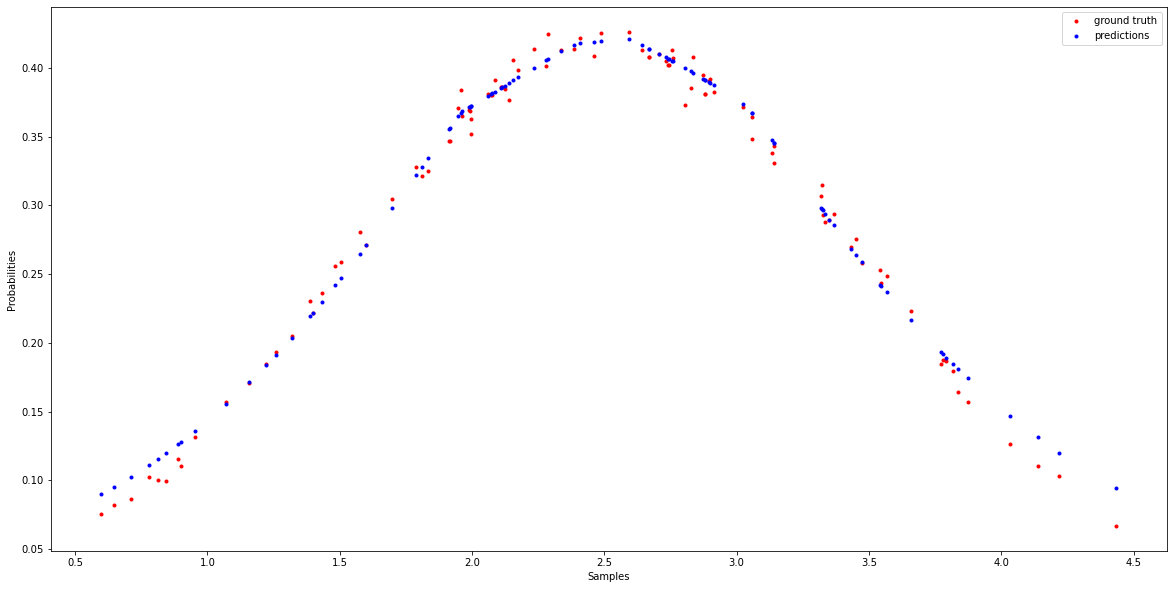

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(X_raw[int(.9*number_of_samples):],Y_test,'r.')
plt.plot(X_raw[int(.9*number_of_samples):],np.transpose(Y_test_hat),'b.')
plt.legend(["ground truth", "predictions"])
plt.xlabel('Samples')
plt.ylabel('Probabilities')
plt.show

## References

1.  https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb

2. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
